TODO:
- Need to rethink method parameters. 
- May need to move to logspace. 
- Once done we can confirm against single integral case.
    
    
The arguments should be the five hyperparameters, the observational noise, the observed luminosities and corresponding redshifts, the number of samples, and the mass function prior.

In [143]:
len(data.lum)

115919

In [145]:
data.columns

Index([u'Unnamed: 0', u'gal_id', u'z', u'ra', u'dec', u'lum', u'lum_obs',
       u'mass'],
      dtype='object')

In [211]:
def importance_sampling_integration(a1, a2, a3, a4, S, nsamples=10**6):
    rev_S = 5.6578015811698101 * S
    lums = lognorm(sigma, scale=true_lum_obs).rvs(size=nsamples)
    mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    masses = lognorm(rev_S, scale=mu_mass).rvs()
    integral = np.sum((p1(true_lum_obs, lums, sigma) * \
            p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)) / \
                (q1(lums, true_lum_obs, sigma) * q2(masses, lums, a1, a2, a3, a4, rev_S, true_z))) /\
            len(lums)
    return integral

def numerical_integration(a1, a2, a3, a4, S, nsamples=10**3):
    masses = midpoints(prior.fetch(true_z).mass[1:])
    delta_masses = np.diff(prior.fetch(true_z).mass[1:])
    lums_tmp = np.logspace(log10(np.min(data.lum_obs)), log10(np.max(data.lum_obs)), nsamples)
    lums = midpoints(lums_tmp)
    delta_lums = np.diff(lums_tmp)
    integral = 0
    for i,lum in enumerate(lums):
        integral += np.sum(delta_masses * delta_lums[i] * p1(true_lum_obs, lum, sigma) * \
            p2(lum, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z))
    return integral

def multi_numerical_integration(lum_obs, zs, a1, a2, a3, a4, S, prior, sigma=0.05, nsamples = 10**3):
    n = len(lum_obs)
    mass_rows = 412
    if n != len(zs):
        raise Error('lum_obs and zs must be same length!')
    masses = np.zeros((n, mass_rows))
    delta_masses = np.zeros((n, mass_rows))
    lums = np.zeros((n, nsamples-1))
    delta_lums = np.zeros((n, nsamples-1))
    for i,z in enumerate(zs):
        masses[i,:] = midpoints(prior.fetch(z).mass[1:])
        delta_masses[i,:] = np.diff(prior.fetch(z).mass[1:])
        lums_tmp = np.logspace(log10(np.min(data.lum_obs)), log10(np.max(data.lum_obs)), nsamples)
        lums[i,:] = midpoints(lums_tmp)
        delta_lums[i,:] = np.diff(lums_tmp)
    integrals = np.zeros(len(zs))
    for j in xrange(nsamples-1):
        for i in xrange(n):
            integrals[i] += np.sum(delta_masses[i,:] * delta_lums[i,j] * p1(lum_obs[i], lums[i,j], sigma) * \
                p2(lums[i,j], masses[i,:], a1, a2, a3, a4, S, zs[i]) * p3(masses[i,:], zs[i], prior))
    return np.prod(integrals)

def multi_importance_sampling(lum_obs, zs, a1, a2, a3, a4, S, prior, sigma=0.05, nsamples = 10**4):
    n = len(lum_obs)
    if n != len(zs):
        raise Error('lum_obs and zs must be same length!')
    rev_S = 5.6578015811698101 * S
    result = 1
    for i in xrange(n):
        lums = lognorm(sigma, scale=lum_obs[i]).rvs(size=nsamples)
        mu_mass = a3 * (lums / (np.exp(a1) * (1 + zs[i]) ** a4)) ** (1 / a2)
        masses = lognorm(rev_S, scale=mu_mass).rvs()
        result *= np.sum((p1(lum_obs[i], lums, sigma) * \
                           p2(lums, masses, a1, a2, a3, a4, S, zs[i]) * \
                           p3(masses, zs[i], prior)) / \
                          (q1(lums, lum_obs[i], sigma) *\
                           q2(masses, lums, a1, a2, a3, a4, rev_S, zs[i]))) /\
                    nsamples
    return result

def log_multi_importance_sampling(lum_obs, zs, a1, a2, a3, a4, S, prior, sigma=0.05, nsamples = 10**4):
    n = len(lum_obs)
    if n != len(zs):
        raise Error('lum_obs and zs must be same length!')
    rev_S = 5.6578015811698101 * S
    result = 0
    for i in xrange(n):
        lums = lognorm(sigma, scale=lum_obs[i]).rvs(size=nsamples)
        mu_mass = a3 * (lums / (np.exp(a1) * (1 + zs[i]) ** a4)) ** (1 / a2)
        masses = lognorm(rev_S, scale=mu_mass).rvs()
        result += np.log(np.sum((p1(lum_obs[i], lums, sigma) * \
                           p2(lums, masses, a1, a2, a3, a4, S, zs[i]) * \
                           p3(masses, zs[i], prior)) / \
                          (q1(lums, lum_obs[i], sigma) *\
                           q2(masses, lums, a1, a2, a3, a4, rev_S, zs[i]))) /\
                    nsamples)
    return result

def neg_log_integrand_generator(lum_obs, zs, a1, a2, a3, a4, S, prior, sigma):
    n = len(lum_obs)
    def neg_log_integrand(prms):
        mass = np.exp(prms[:n])
        lum = np.exp(prms[n:])
        return np.sum(- logp1(lum_obs, lum, sigma) \
            - logp2(lum, mass, a1, a2, a3, a4, S, zs) \
            - logp3_la(mass, zs, prior))
    return neg_log_integrand

def multi_laplace_approximation(lum_obs, zs, a1, a2, a3, a4, S, prior, sigma=0.05):
    n = 2 * len(lum_obs)
    x0 = np.array([np.log(10**11)] * (n/2) +  [np.log(10**4)] * (n/2))
    neg_log_integrand = neg_log_integrand_generator(lum_obs, zs, a1, a2, a3, a4, S, prior, sigma)
    ans = minimize(neg_log_integrand, x0, method='BFGS')
    h_ln = np.linalg.inv(ans['hess_inv'])
    ln_transform = np.tile(1 / np.exp(ans['x']), n).reshape(n, n)
    h = np.multiply(h_ln, np.multiply(ln_transform, ln_transform.transpose()))
    print h
    result = 0
    for i in xrange(n / 2):
        result *= np.exp(-neg_log_integrand(ans['x'])) * sqrt((2 * np.pi) ** (2) / np.linalg.det(h))
        # TODO

#### Scaling Up With Number of Halos

In [139]:
n = 5
a1,a2,a3,a4,S = get()
prior = TinkerPrior(Grid()) 

timevalslong = np.zeros(n)
space = np.logspace(1, log10(len(data.lum_obs)), n)
for i, nhalos in enumerate(space):
    nhalos = int(nhalos)
    lum_obs = data.lum_obs.as_matrix()[:nhalos]
    zs = data.z.as_matrix()[:nhalos]
    start = time()
    multi_importance_sampling(lum_obs, zs, a1, a2, a3, a4, S, prior)
    end = time()
    timevalslong[i][1] = end - start


In [194]:
n = 5
a1,a2,a3,a4,S = get()
prior = TinkerPrior(Grid()) 

timevalslong2 = np.zeros(n)
space2 = np.logspace(1, 2, n)
for i, nhalos in enumerate(space2):
    nhalos = int(nhalos)
    lum_obs = data.lum_obs.as_matrix()[:nhalos]
    zs = data.z.as_matrix()[:nhalos]
    start = time()
    multi_numerical_integration(lum_obs, zs, a1, a2, a3, a4, S, prior)
    end = time()
    timevalslong2[i] = end - start

In [200]:
timevalslong3

array([  1.34516907e+00,   1.39662835e+01,   1.45569218e+02,
         1.50997008e+03,   1.56848250e+04])

In [201]:
timevalslong

array([  6.96299076e-02,   7.22935915e-01,   7.53509092e+00,
         7.81604929e+01,   8.11892679e+02])

In [198]:
timevalslong3 = (timevalslong2[0] / timevalslong[0]) * timevalslong

In [222]:
(timevalslong[0] / 10) * len(data.lum)

807.14292600154886

In [223]:
(timevalslong3[0] / 10) * len(data.lum)

15593.065312194825

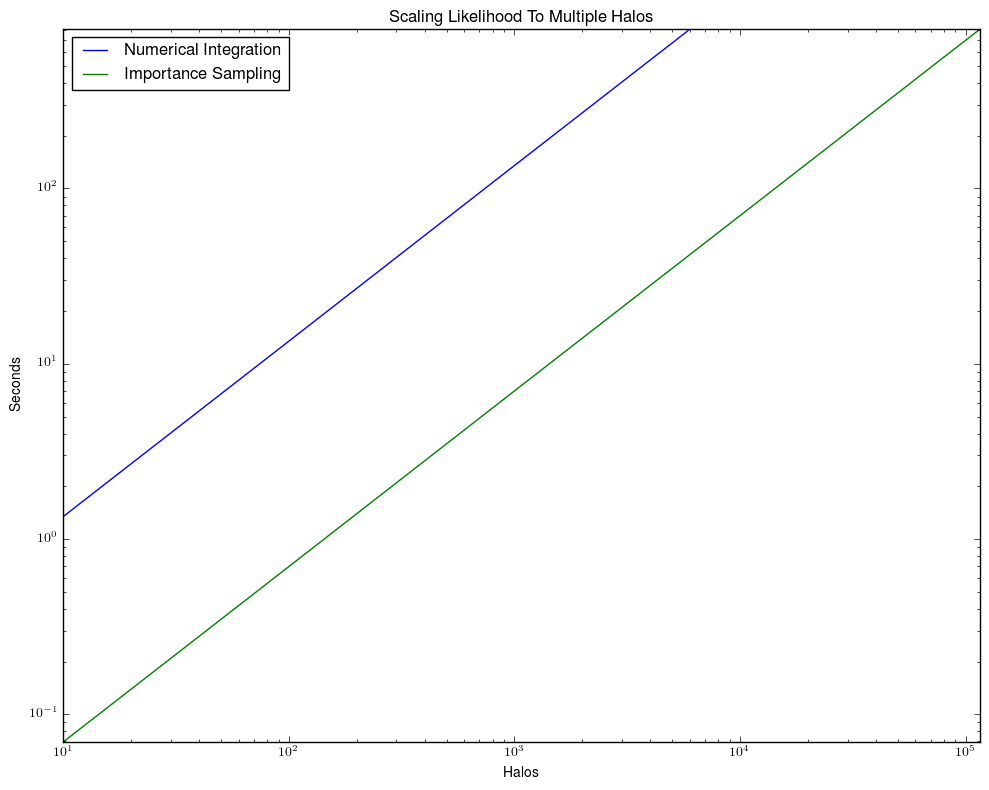

In [234]:
space = np.logspace(1, log10(len(data.lum_obs)), n)

plt.plot(space, timevalslong3, label='Numerical Integration')
plt.plot(space, timevalslong, label='Importance Sampling')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Scaling Likelihood To Multiple Halos')
plt.xlabel('Halos')
plt.ylabel('Seconds')
plt.legend(loc=2)
plt.xlim([space.min(), space.max()])
plt.ylim([timevalslong[0], timevalslong[-1]])
plt.gcf().set_size_inches(10,8)
plt.tight_layout();

In [136]:
n = 10
a1,a2,a3,a4,S = get()
prior = TinkerPrior(Grid()) 

vals = np.zeros((n, 2))
timevals = np.zeros((n, 2))
space = np.logspace(1, 2, n)
for i, nhalos in enumerate(space):
    nhalos = int(nhalos)
    lum_obs = data.lum_obs.as_matrix()[:nhalos]
    zs = data.z.as_matrix()[:nhalos]
    start = time()
    vals[i][0] = (multi_numerical_integration(lum_obs, zs, a1, a2, a3, a4, S, prior)) ** (1. / nhalos)
    end = time()
    timevals[i][0] = end - start

    start = time()
    vals[i][1] = (multi_importance_sampling(lum_obs, zs, a1, a2, a3, a4, S, prior)) ** (1. / nhalos)
    end = time()
    timevals[i][1] = end - start

plot average integral value.

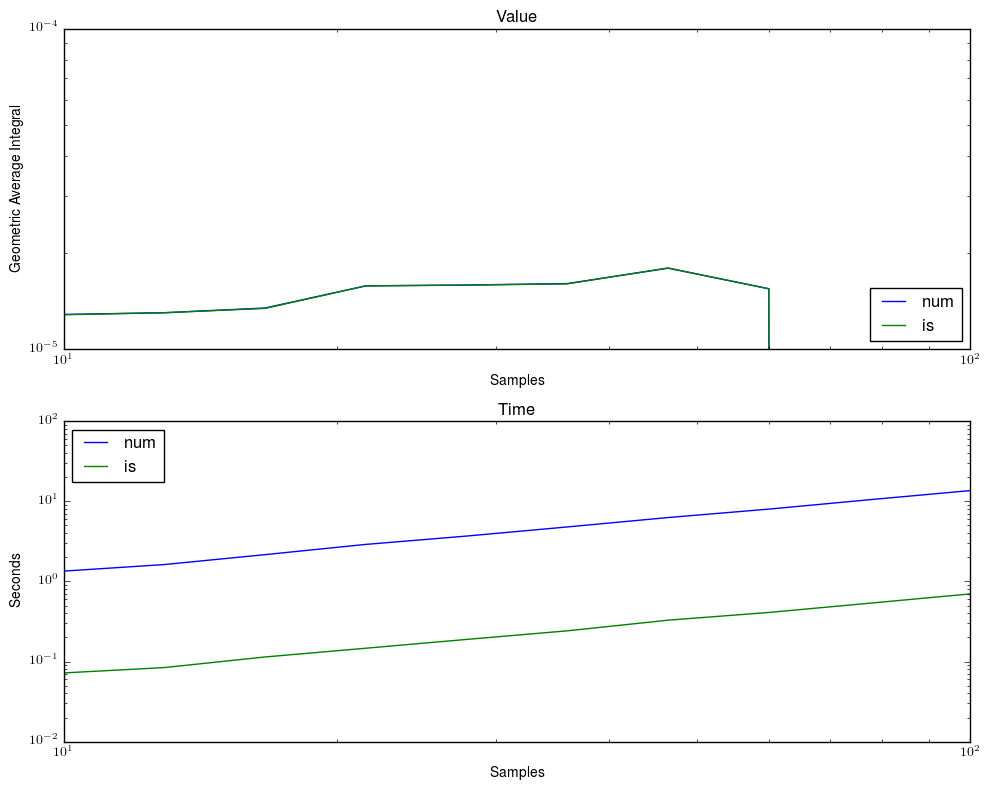

In [137]:
plt.subplot(211)
plt.plot(space, vals[:,0], label='num')
plt.plot(space, vals[:,1], label='is')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Value')
plt.xlabel('Samples')
plt.ylabel('Geometric Average Integral')
plt.legend(loc=4)

plt.subplot(212)
plt.plot(space, timevals[:,0], label='num')
plt.plot(space, timevals[:,1], label='is')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Time')
plt.xlabel('Samples')
plt.ylabel('Seconds')
plt.legend(loc=2)
# plt.xlim([10,10**5])

plt.gcf().set_size_inches(10,8)
plt.tight_layout();

# JIT

In [129]:
n = 10
a1,a2,a3,a4,S = get()
prior = TinkerPrior(Grid()) 

vals = np.zeros((n, 2))
timevals = np.zeros((n, 2))
space = np.logspace(1, 3, n)
for i, nhalos in enumerate(space):
    nhalos = int(nhalos)
    lum_obs = data.lum_obs.as_matrix()[:nhalos]
    zs = data.z.as_matrix()[:nhalos]
    start = time()
#     vals[i][0] = multi_numerical_integration(lum_obs, zs, a1, a2, a3, a4, S, prior)
    end = time()
    timevals[i][0] = end - start

    start = time()
    vals[i][1] = multi_importance_sampling(lum_obs, zs, a1, a2, a3, a4, S, prior)
    end = time()
    timevals[i][1] = end - start

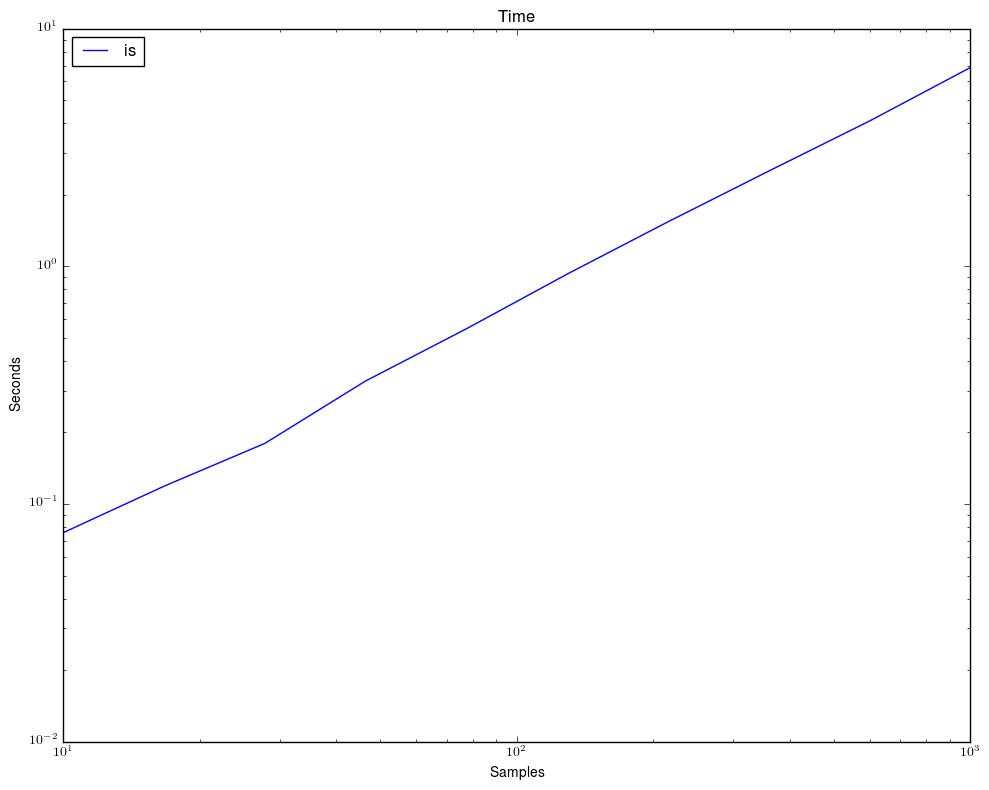

In [130]:
# plt.subplot(211)
# # plt.plot(logspace, vals[:,0], label='num')
# plt.plot(space, vals[:,1], label='is')
# plt.gca().set_xscale('log')
# plt.gca().set_yscale('log')
# plt.title('Value')
# plt.xlabel('Samples')
# plt.ylabel('Integral')
# # plt.xlim([10,10**5])
# plt.legend(loc=4)

# plt.subplot(212)
# plt.plot(logspace, timevals[:,0], label='num')
plt.plot(space, timevals[:,1], label='is')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Time')
plt.xlabel('Samples')
plt.ylabel('Seconds')
plt.legend(loc=2)
# plt.xlim([10,10**5])

plt.gcf().set_size_inches(10,8)
plt.tight_layout();

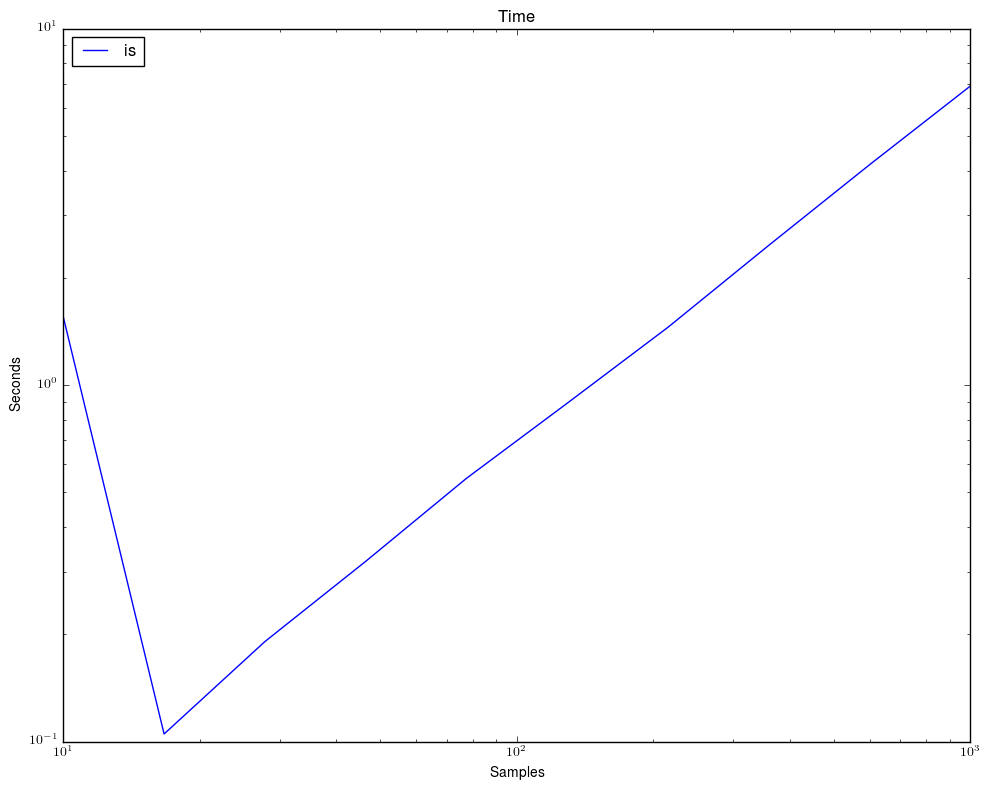

In [128]:
# plt.subplot(211)
# # plt.plot(logspace, vals[:,0], label='num')
# plt.plot(space, vals[:,1], label='is')
# plt.gca().set_xscale('log')
# plt.gca().set_yscale('log')
# plt.title('Value')
# plt.xlabel('Samples')
# plt.ylabel('Integral')
# # plt.xlim([10,10**5])
# plt.legend(loc=4)

# plt.subplot(212)
# plt.plot(logspace, timevals[:,0], label='num')
plt.plot(space, timevals[:,1], label='is')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Time')
plt.xlabel('Samples')
plt.ylabel('Seconds')
plt.legend(loc=2)
# plt.xlim([10,10**5])

plt.gcf().set_size_inches(10,8)
plt.tight_layout();

In [111]:
lum_obs = data.lum_obs.as_matrix()[:10]
zs = data.z.as_matrix()[:10]
a1,a2,a3,a4,S = get()
prior = TinkerPrior(Grid()) 

%time print multi_importance_sampling(lum_obs, zs, a1, a2, a3, a4, S, prior)
%time print multi_numerical_integration(lum_obs, zs, a1, a2, a3, a4, S, prior)

1.18315447162e-49
CPU times: user 63.8 ms, sys: 179 µs, total: 64 ms
Wall time: 64.1 ms
[  1.16445344e-05   7.98309146e-05   3.35356140e-06   2.22511923e-05
   1.89544784e-05   1.58634043e-07   6.53662584e-05   9.07087053e-06
   2.20638922e-05   4.43354784e-05]
1.20975418114e-49
CPU times: user 12.6 s, sys: 23.5 ms, total: 12.6 s
Wall time: 12.6 s


In [175]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rc
from matplotlib import cm
import matplotlib.colors as colors
from bigmali.grid import Grid
from bigmali.likelihood import BiasedLikelihood
from bigmali.prior import TinkerPrior
from bigmali.hyperparameter import get
from scipy.stats import lognorm
from time import time
import seaborn.apionly as sns
from scipy.optimize import minimize
from math import sqrt
from time import time
rc('text', usetex=True)

data = pd.read_csv('/Users/user/Code/PanglossNotebooks/MassLuminosityProject/mock_data.csv')

def p1(lobs, lum, sigma):
    return fast_lognormal(lum, sigma, lobs)

def p2(lum, mass, a1, a2, a3, a4, S, z):
    mu_lum = np.exp(a1) * ((mass / a3) ** a2) * ((1 + z) ** (a4))
    return fast_lognormal(mu_lum, S, lum)
    
def p3(mass, z, prior):
    return prior.fetch(z).pdf(mass)

def q1(lum, lobs, sigma):
    return fast_lognormal(lobs, sigma, lum)
    
def q2(mass, lum, a1, a2, a3, a4, S, z):
    mu_mass = a3 * (lum / (np.exp(a1) * (1 + z) ** a4)) ** (1 / a2)
    return fast_lognormal(mu_mass, S, mass)

def logp1(lobs, lum, sigma):
    return fast_log_lognormal(lum, sigma, lobs)

def logp2(lum, mass, a1, a2, a3, a4, S, z):
    mu_lum = np.exp(a1) * ((mass / a3) ** a2) * ((1 + z) ** (a4))
    return fast_log_lognormal(mu_lum, S, lum)

def logp3_la(masses, zs, prior):
    res = 0
    for i in xrange(len(masses)):
         res += prior.fetch(zs[i]).logpdf(masses[i])
    return res

def logp3_is(mass, z, prior):
    return prior.fetch(z).logpdf(mass)

def logq1(lum, lobs, sigma):
    return fast_log_lognormal(lobs, sigma, lum)
    
def logq2(mass, lum, a1, a2, a3, a4, S, z):
    mu_mass = a3 * (lum / (np.exp(a1) * (1 + z) ** a4)) ** (1 / a2)
    return fast_log_lognormal(mu_mass, S, mass)

def midpoints(arr):
    n = len(arr)-1
    ret = np.zeros(n)
    for i in xrange(n):
        ret[i] = (arr[i+1] + arr[i]) / 2.
    return ret

def fast_lognormal(mu, sigma, x):
    return  (1/(x * sigma * np.sqrt(2 * np.pi))) * np.exp(- 0.5 * (np.log(x) - np.log(mu)) ** 2 / sigma ** 2)

def fast_log_lognormal(mu, sigma, x):
    return  -np.log(x * sigma * np.sqrt(2 * np.pi)) - 0.5 * (np.log(x) - np.log(mu)) ** 2 / sigma ** 2

def log10(arr):
    return np.log(arr) / np.log(10)

# Reproducing Seed Hyper-parameters.

In [155]:
perm = np.random.permutation(data.as_matrix())

In [157]:
data.columns

Index([u'Unnamed: 0', u'gal_id', u'z', u'ra', u'dec', u'lum', u'lum_obs',
       u'mass'],
      dtype='object')

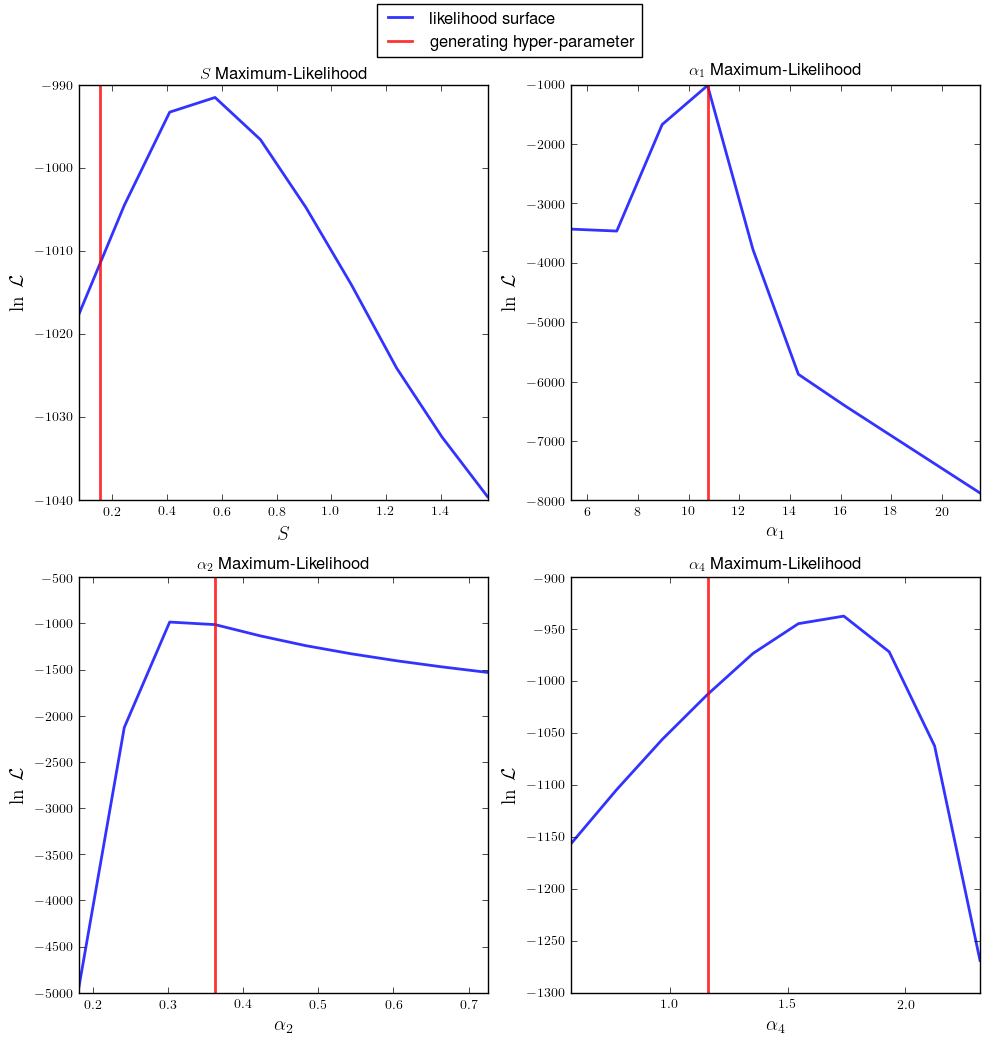

In [242]:
perm = np.random.permutation(data.as_matrix())
lum_obs = perm[:100,6]
zs = perm[:100,2]
a1,a2,a3,a4,S = get()
prior = TinkerPrior(Grid()) 

plt.subplot(2,2,1)
space = S * np.linspace(0.5, 10, 10)
vals = []
for i,test in enumerate(space):
    vals.append(log_multi_importance_sampling(lum_obs, zs, a1, a2, a3, a4, test, prior, sigma=0.05, nsamples = 10**3))
plt.plot(space, vals, alpha=0.8, linewidth=2)
plt.title(r'$S$ Maximum-Likelihood')
plt.xlabel(r'$S$', fontsize=14)
plt.ylabel(r'$\ln\ \mathcal{L}$', fontsize=14)
plt.gca().axvline(S, color='red', linewidth=2, alpha=0.8)
plt.xlim([space.min(), space.max()])

plt.subplot(2,2,2)
space = a1 * np.linspace(0.5, 2, 10)
vals = []
for i,test in enumerate(space):
    vals.append(log_multi_importance_sampling(lum_obs, zs, test, a2, a3, a4, S, prior, sigma=0.05, nsamples = 10**3))
plt.plot(space, vals, alpha=0.8, linewidth=2)
plt.title(r'$\alpha_1$ Maximum-Likelihood')
plt.xlabel(r'$\alpha_1$', fontsize=14)
plt.ylabel(r'$\ln\ \mathcal{L}$', fontsize=14)
plt.gca().axvline(a1, color='red', linewidth=2, alpha=0.8)
plt.xlim([space.min(), space.max()])

plt.subplot(2,2,3)
space = a2 * np.linspace(0.5, 2, 10)
vals = []
for i,test in enumerate(space):
    vals.append(log_multi_importance_sampling(lum_obs, zs, a1, test, a3, a4, S, prior, sigma=0.05, nsamples = 10**3))
plt.plot(space, vals, alpha=0.8, linewidth=2)
plt.title(r'$\alpha_2$ Maximum-Likelihood')
plt.xlabel(r'$\alpha_2$', fontsize=14)
plt.ylabel(r'$\ln\ \mathcal{L}$', fontsize=14)
plt.gca().axvline(a2, color='red', linewidth=2, alpha=0.8)
plt.xlim([space.min(), space.max()])

plt.subplot(2,2,4)
space = a4 * np.linspace(0.5, 2, 10)
vals = []
for i,test in enumerate(space):
    vals.append(log_multi_importance_sampling(lum_obs, zs, a1, a2, a3, test, S, prior, sigma=0.05, nsamples = 10**3))
l1, = plt.plot(space, vals, alpha=0.8, linewidth=2)
plt.title(r'$\alpha_4$ Maximum-Likelihood')
plt.xlabel(r'$\alpha_4$', fontsize=14)
plt.ylabel(r'$\ln\ \mathcal{L}$', fontsize=14)
l2 = plt.gca().axvline(a4, color='red', linewidth=2, alpha=0.8)
plt.xlim([space.min(), space.max()])

plt.gcf().legend((l1,l2), 
                 ('likelihood surface','generating hyper-parameter'),
                bbox_to_anchor=(0.65, 1.05))

plt.gcf().set_size_inches(10,10)
plt.tight_layout()